# Chapter03 Decision Tree

> 这里用到的脚本在章节目录的文件夹中都可以找到，就不再贴在此处了，只展示用法

摘自：[决策树 – Decision tree](https://easyai.tech/ai-definition/decision-tree/)

决策树是一种分类算法，其采用树形结构，使用层层推理来实现最终的分类。决策树由下面几种元素构成：

- 根节点：包含样本的全集
- 内部节点：对应特征属性测试
- 叶节点：代表决策的结果

![决策树的结构](https://easy-ai.oss-cn-shanghai.aliyuncs.com/2019-09-17-jiegou.png)

预测时，在树的内部节点处用某一属性值进行判断，根据判断结果决定进入哪个分支节点，直到到达叶节点处，得到分类结果。

**决策树学习的三个步骤**
![image.png](https://easy-ai.oss-cn-shanghai.aliyuncs.com/2019-09-17-3steps.png)



**典型决策树算法**
1. ID3 (本节书中用到的方法)
2. C4.5
3. CART


## 决策树特征

监督式学习方法

- 优点：计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据
- 缺点：可能会产生过度匹配的问题

# 决策树的构造

使用书中的海洋生物数据进行决策树算法的演示：

| 不浮出水面是否可以生存 | 是否具有脚蹼 | 属于鱼类 |
|----------------------|-----|------|
| yes                  | yes | yes  |
| yes                  | yes | yes  |
| yes                  | no  | no   |
| no                   | yes | no   |
| no                   | yes | no   |

我们将前两列转换为0，1值作为特征，第三列作为标签，构建数据集。

In [7]:
import trees
myDat, labels=trees.createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

决策树对数据的分类是通过对数据不断划分而实现的。划分数据集的大原则是：将无需的数据变得更加有序。而对数据有序程度的一种衡量方法是熵（entropy）。有序组织的数据当中包含较少的冗余信息，熵也较小；反之，杂乱无章的数据的具有更多的冗余信息，熵会较高。

> https://zh.wikipedia.org/wiki/%E7%86%B5_(%E4%BF%A1%E6%81%AF%E8%AE%BA)

因此，我们可以用香农熵评估数据划分的效果

香农熵的计算公式如下：

${H(X)=E[I(X)]=E[-ln(P(X))]}$

其中，P为X的概率函数，E为期望函数，而I(X)是X的信息量（又称为自信息）。I(X)本身是个随机变数。

当样本数量有限时，上式可写为：

${H(X)=-\sum^{n}_{i=1} p(x_i) log_2 p(x_i)}$

接着，我们使用函数 `trees.calcShannonEnt(dataSet)` 计算香农熵

In [4]:
trees.calcShannonEnt(myDat)

0.9709505944546686

如果熵越高，说明数据的混合程度（无序性）也越高。我们在这组数据中添加分类，再计算香农熵：

In [5]:
myDat[0][-1] = 'maybe'
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [6]:
trees.calcShannonEnt(myDat)

1.3709505944546687

熵是我们评估数据集有序性的方法。对于分类算法来说，我们需要的是根据**特征**切分数据集，然后利用熵评估子数据集的有序性，以此判断分类是否正确。

我们以第一列特征展示如何使用 `trees.splitDataSet(dataSet, axis, value)` 切分数据集。

In [8]:
from importlib import reload
reload(trees)
myDat, labels=trees.createDataSet()
trees.splitDataSet(myDat, 0, 1) #first column equals to 1?

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [9]:
trees.splitDataSet(myDat, 0, 0) #first column equals to 0?

[[1, 'no'], [1, 'no']]

我们根据 `value` 的值将原数据集切分成了两个子数据集。

通常，我们需要尝试使用数据集中的多个特征值对数据集进行切分来获得最优的特征。

这里使用 `trees.chooseBestFeatureToSplit(dataSet)` 来遍历整个数据集，通过判断子数据集熵的方法来获得最优分类特征。


In [10]:
trees.chooseBestFeatureToSplit(myDat)

0

该函数表明最优的划分特征是第一列，也就是该海洋生物“不浮出水面是否可以生存”。这里分别手动计算两种情况的香农熵，比较一下

In [16]:
trees.calcShannonEnt(trees.splitDataSet(myDat, 0, 0)) + trees.calcShannonEnt(trees.splitDataSet(myDat, 0, 1)) 

0.9182958340544896

In [17]:
trees.calcShannonEnt(trees.splitDataSet(myDat, 1, 0)) + trees.calcShannonEnt(trees.splitDataSet(myDat, 1, 1)) 

1.0

可以发现使用第二列划分数据时的熵要大于使用第一列，证明第一列是当前最优的分类特征

接下来，使用 `createTree(dataSet, labels)` 函数来创建决策树

In [21]:
reload(trees)
myDat, labels = trees.createDataSet()
myTree = trees.createTree(myDat, labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

`myTree` 是一个嵌套字典，代表了我们的树结构，其中如果值是类标签，则代表了一个叶节点，如果是一个字典，那就是一个内部判断节点。

接下来，根据 `treePlotter.createPlot(inTree)` 绘制树形图

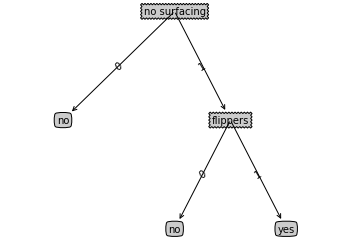

In [22]:
import treePlotter
myTree = treePlotter.retrieveTree(0) #pre-stored tree 
treePlotter.createPlot(myTree)

通过对决策树的可视化，我们可以发现该决策树的分类流程：
1. 判断输入向量的第一个特征“是否可以浮出水面生活”，如果为1则进入下一级判断；为0则分类为“非鱼类（no）”
2. 判断输入向量的第二个特征“是否具有脚蹼”，如果为1则分类为“鱼类（yes）”；为0则分类为“非鱼类（no）”


# 测试算法：使用决策树执行分类

构建决策树后，我们可以输入特征向量给决策树，看它的分类结果

In [23]:
reload(trees)
myDat, labels = trees.createDataSet()
myTree = treePlotter.retrieveTree(0) #pre-stored tree 
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [25]:
trees.classify(myTree, labels, [1,0])

'no'

In [28]:
trees.classify(myTree, labels, [1,1])

'yes'

比较上面的树结构，当第一列为1且第二列为0时，输出标签为 `no`; 当第一列为1且第二列为1时，输出标签为 `yes`


# 示例：使用决策树预测隐形眼镜适用类型

In [30]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = trees.createTree(lenses, lensesLabels)
lensesTree

{'tearRate': {'normal': {'astigmatic': {'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}},
    'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}}}},
  'reduced': 'no lenses'}}

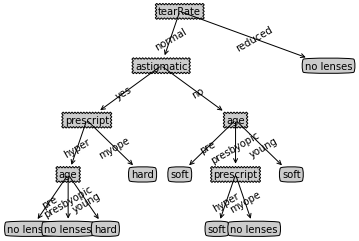

In [31]:
treePlotter.createPlot(lensesTree)

上述决策树告诉我们最多输入四个向量，我们就可以完成对隐形眼镜类型的分类。